In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
from scipy.integrate import quad
import pandas as pd

from pyvbmc import VBMC
import random
import os
from tqdm import tqdm
from trunc_censoring_aborts_utils import rho_A_t_fn, cum_A_t_fn
import corner


# data

In [2]:
# read out_LED.csv as dataframe
og_df = pd.read_csv('../out_LED.csv')

# chose non repeat trials - 0 or 2 or missing
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]

# only session type 7
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]

# training level 16
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

# find ABL and ILD
ABL_arr = df['ABL'].unique()
ILD_arr = df['ILD'].unique()


# sort ILD arr in ascending order
ILD_arr = np.sort(ILD_arr)
ABL_arr = np.sort(ABL_arr)

print('ABL:', ABL_arr)
print('ILD:', ILD_arr)

ABL: [20 40 60]
ILD: [-16.  -8.  -4.  -2.  -1.   1.   2.   4.   8.  16.]


# LED on or off

In [3]:
LED_TRIAL = 0

df_to_fit = df[ df['LED_trial'] == LED_TRIAL ] 

# VBMC

In [4]:
T_trunc = 0.3

## likelihood

In [5]:
def compute_loglike(row, V_A, theta_A, t_A_aff, pdf_trunc_factor):
    t_stim = row['intended_fix']
    rt = row['timed_fix']

    if rt < T_trunc:
        likelihood = 0
    else:
        if rt < t_stim:
            likelihood =  rho_A_t_fn(rt - t_A_aff, V_A, theta_A) / pdf_trunc_factor
        elif rt > t_stim:
            likelihood = ( 1 - cum_A_t_fn(t_stim - t_A_aff, V_A, theta_A) ) / pdf_trunc_factor

    if likelihood <= 0:
        likelihood = 1e-50

    
    return np.log(likelihood)    



def psiam_tied_loglike_fn(params):
    V_A, theta_A, t_A_aff = params

    pdf_trunc_factor = 1 - cum_A_t_fn(T_trunc - t_A_aff, V_A, theta_A)
    all_loglike = Parallel(n_jobs=-1)(delayed(compute_loglike)(row, V_A, theta_A, t_A_aff, pdf_trunc_factor) \
                                       for _, row in df_to_fit.iterrows() if (not np.isnan(row['timed_fix'] + row['intended_fix']) ))
                                   


    loglike = np.sum(all_loglike)
    return loglike

## bounds

In [6]:
V_A_bounds = [0.1, 5]
theta_A_bounds = [0.1, 5]
t_A_aff_bounds = [0.01, 0.09]

V_A_plausible_bounds = [0.5, 3]
theta_A_plausible_bounds = [0.5, 3]
t_A_aff_plausible_bounds = [0.03, 0.06]

## prior

In [7]:
def trapezoidal_logpdf(x, a, b, c, d):
    if x < a or x > d:
        return -np.inf  # Logarithm of zero
    area = ((b - a) + (d - c)) / 2 + (c - b)
    h_max = 1.0 / area  # Height of the trapezoid to normalize the area to 1
    
    if a <= x <= b:
        pdf_value = ((x - a) / (b - a)) * h_max
    elif b < x < c:
        pdf_value = h_max
    elif c <= x <= d:
        pdf_value = ((d - x) / (d - c)) * h_max
    else:
        pdf_value = 0.0  # This case is redundant due to the initial check

    if pdf_value <= 0.0:
        return -np.inf
    else:
        return np.log(pdf_value)
    

def vbmc_prior_abort_fn(params):
    V_A, theta_A,t_A_aff = params

    V_A_logpdf = trapezoidal_logpdf(V_A, V_A_bounds[0], V_A_plausible_bounds[0], V_A_plausible_bounds[1], V_A_bounds[1])
    theta_A_logpdf = trapezoidal_logpdf(theta_A, theta_A_bounds[0], theta_A_plausible_bounds[0], theta_A_plausible_bounds[1], theta_A_bounds[1])
    t_A_aff_logpdf = trapezoidal_logpdf(t_A_aff, t_A_aff_bounds[0], t_A_aff_plausible_bounds[0], t_A_aff_plausible_bounds[1], t_A_aff_bounds[1])
    return V_A_logpdf + theta_A_logpdf + t_A_aff_logpdf

## prior + likelihood

In [8]:
def vbmc_joint(params):
    return vbmc_prior_abort_fn(params) + psiam_tied_loglike_fn(params)

## run vbmc

In [9]:
lb = [V_A_bounds[0], theta_A_bounds[0], t_A_aff_bounds[0]]
ub = [V_A_bounds[1], theta_A_bounds[1], t_A_aff_bounds[1]]


plb = [V_A_plausible_bounds[0], theta_A_plausible_bounds[0], t_A_aff_plausible_bounds[0]]
pub = [V_A_plausible_bounds[1], theta_A_plausible_bounds[1], t_A_aff_plausible_bounds[1]]

np.random.seed(42)
V_A_0 = np.random.uniform(V_A_plausible_bounds[0], V_A_plausible_bounds[1])
theta_A_0 = np.random.uniform(theta_A_plausible_bounds[0], theta_A_plausible_bounds[1])
t_A_aff_0 = np.random.uniform(t_A_aff_plausible_bounds[0], t_A_aff_plausible_bounds[1])

x_0 = np.array([V_A_0, theta_A_0, t_A_aff_0])


In [10]:
vbmc = VBMC(vbmc_joint, x_0, lb, ub, plb, pub, options={'display': 'off'})
vp, results = vbmc.optimize()

Reshaping x0 to row vector.
Reshaping lower bounds to (1, 3).
Reshaping upper bounds to (1, 3).
Reshaping plausible lower bounds to (1, 3).
Reshaping plausible upper bounds to (1, 3).
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -241209.415 +/-0.001.


## save

In [11]:
vp.save(f'trunc_and_censor_fit_aborts_LED_{LED_TRIAL}.pkl', overwrite=True)

# Diagnostics

## corner

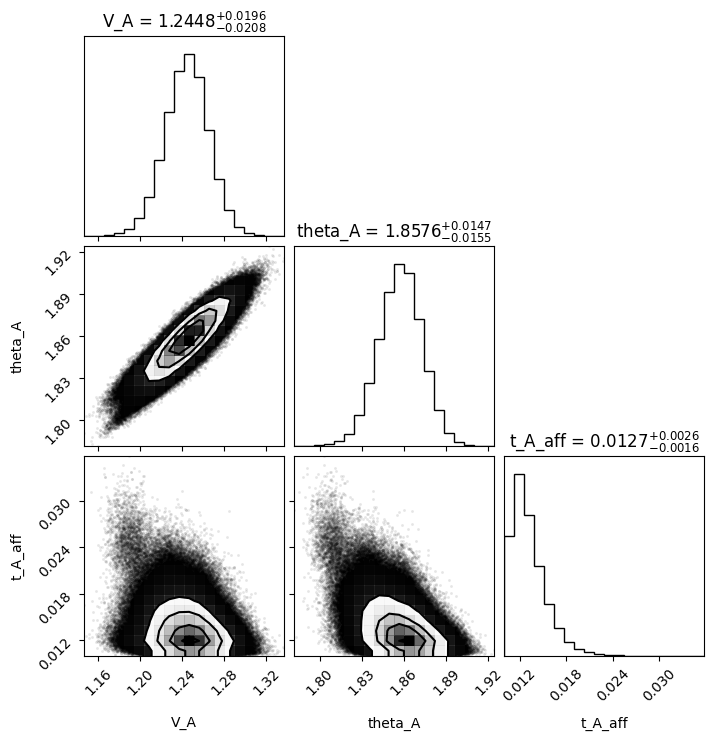

In [12]:
vp_samples = vp.sample(int(1e6))[0]
V_A_samp = vp_samples[:,0]
theta_A_samp = vp_samples[:,1]
t_A_aff_samp = vp_samples[:,2]

combined_samples = np.transpose(np.vstack((V_A_samp, theta_A_samp, t_A_aff_samp)))
param_labels = ['V_A', 'theta_A', 't_A_aff']
corner.corner (combined_samples, labels=param_labels, show_titles=True, title_fmt=".4f" );


## fit and see

In [13]:
t_stim_0 = 0.2
t_stim_tau = 0.4
def prob_hit_and_fix_survive(t, t_stim_0, t_stim_tau, V_A, theta_A, t_A_aff):
    if t < t_stim_0:
        fix_survive = 1
    else:
        fix_survive = np.exp(-(t - t_stim_0)/t_stim_tau)
    
    return rho_A_t_fn(t-t_A_aff, V_A, theta_A) * fix_survive
    

def pdf_aborts(t, t_stim_0, t_stim_tau, V_A, theta_A, T_trunc, t_A_aff, PDF_trunc_factor):
    """
    pdf of aborts with stim time
    """
    if t < T_trunc:
        return 0

    pdf_hit_and_fix_survive_truncated = prob_hit_and_fix_survive(t, t_stim_0, t_stim_tau, V_A, theta_A, t_A_aff) / PDF_trunc_factor
    return pdf_hit_and_fix_survive_truncated

In [14]:
# data
data_abort_rt = df_to_fit[ (df_to_fit['timed_fix'] < df_to_fit['intended_fix']) & \
                            (df_to_fit['timed_fix'] > T_trunc) ]['timed_fix'].values


bin_width = 0.05
bins = np.arange(0, np.max(data_abort_rt), bin_width)
t_pts = bins[:-1] + bin_width / 2

# theory
V_A = np.mean(V_A_samp)
theta_A = np.mean(theta_A_samp)
t_A_aff = np.mean(t_A_aff_samp)

pdf_trunc_factor = quad(prob_hit_and_fix_survive, T_trunc, 10, args=(t_stim_0, t_stim_tau, V_A, theta_A, t_A_aff))[0]
theory_abort_rt = [pdf_aborts(t, t_stim_0, t_stim_tau, V_A, theta_A, T_trunc, t_A_aff, pdf_trunc_factor) for t in t_pts]

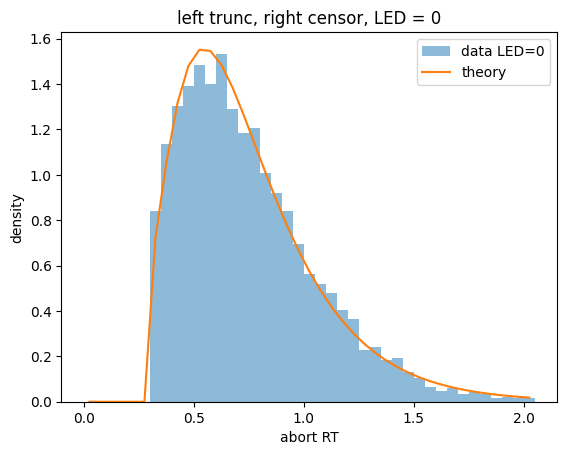

In [15]:
plt.hist(data_abort_rt, bins=bins, density=True, alpha=0.5, label=f'data LED={LED_TRIAL}')
plt.plot(t_pts, theory_abort_rt, label='theory')
plt.xlabel('abort RT')
plt.ylabel('density')
plt.legend()
plt.title(f'left trunc, right censor, LED = {LED_TRIAL}');